In [1]:
%load_ext autoreload

%autoreload 2

import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

from ruspy.data.data_reading import data_reading
from ruspy.data.data_processing import data_processing

from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import calc_fixp
from ruspy.estimation.estimation_cost_parameters import lin_cost
from ruspy.estimation.estimation_cost_parameters import myopic_costs
from ruspy.estimation.estimation_cost_parameters import create_transition_matrix

from ruspy.simulation.simulation import simulate
from ruspy.simulation.robust_sim import get_worst_trans

from ruspy.plotting.value_zero import discount_utility
from ruspy.plotting.value_zero import calc_ev_0

%load_ext snakeviz

In [2]:
# Prepare the raw data.
data_reading()

In [2]:
# Beta is set almost to one, as the agents objective is to maximize average cost.
beta = 0.9999
# 50 buses should be enough to gurantee convergence.
num_buses = 200
# Set the number of simulated periods to 80000. The first plot shows the convergence at this point.
num_periods = 80000

# Paramters for plotting
gridsize = 1000
num_points = int(num_periods/gridsize)

#Initilize a dictionary with values needed on the way.
init_dict = {
    'estimation':{
        'groups': 'group_4',
        'beta': beta,
        'maint_func': 'linear',
        'binsize': 5000,
        'states': 90,
        'max_it': 1000
    },
    'simulation':{
        'beta': beta,
        'periods': num_periods,
        'seed': 123,
        'maint_func': 'linear',
        'buses': num_buses
    }
    
}
np.random.seed(init_dict['simulation']['seed'])

In [3]:
repl_data = data_processing(init_dict['estimation'])
trans_results, cost_results = estimate(init_dict['estimation'], repl_data)
print(trans_results, cost_results)

     fun: 3140.570557231583
     jac: array([-4291.96844482, -4292.02462769, -4291.81420898])
 message: 'Optimization terminated successfully.'
    nfev: 158
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([0.39189477, 0.59529015, 0.01281509])       fun: 163.58583868384702
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373675e-05,  4.26325641e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
   status: 0
  success: True
        x: array([10.07776827,  2.29415225])


In [4]:
init_dict['simulation']['known probs'] = trans_results['x']
init_dict['simulation']['params'] = cost_results['x']

In [4]:
# The estimated probabilities are our starting point.
init_dict['simulation']['known probs'] = trans_results['x']
init_dict['simulation']['params'] = cost_results['x']
# From previos runs, I knwo that the maximal achievable 
# Simulate a dataset with these values.
df, unobs, utilities, num_states = simulate(init_dict['simulation'])

# The theoretic value at time zero is computed.
costs = myopic_costs(num_states, lin_cost, init_dict['simulation']['params'])
trans_probs = np.array(init_dict['simulation']['known probs'])
trans_mat = create_transition_matrix(num_states, trans_probs)
ev = calc_fixp(num_states, trans_mat, costs, beta)

# Calculate the expected value at time zero
v_exp = np.full(num_points, calc_ev_0(ev, unobs, num_buses))
# Calculate the value at time 0 by discounting the utility
v_disc = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities, beta)
# Create a numpy array of the periods for plotting
periods = np.arange(0, num_periods, gridsize)

[]

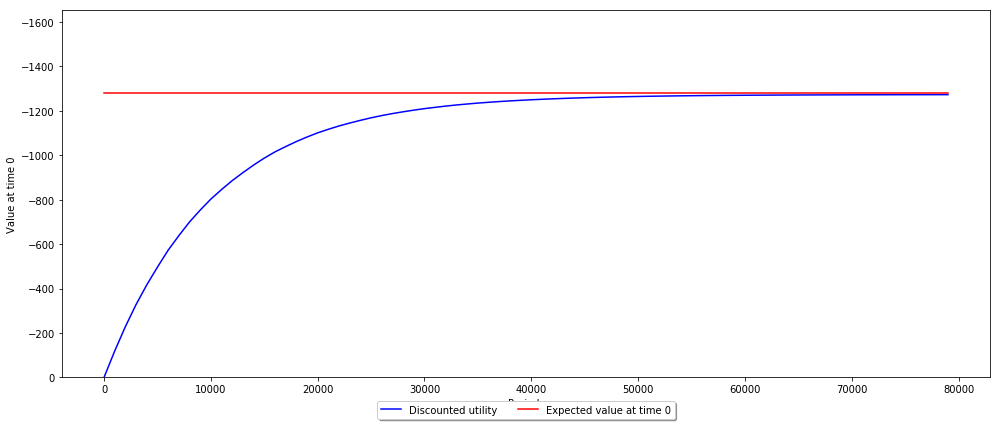

In [5]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0, 1.3 * v_disc[-1]])
ax.set_ylabel(r"Value at time 0")
ax.set_xlabel(r"Periods")
ax.plot(periods, v_disc, color='blue', label='Discounted utility')
ax.plot(periods, v_exp, color='red', label='Expected value at time 0')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

plt.tight_layout()

plt.plot()


# Uncertainty

Now we want to introduce uncertain transition probabilites. Let <br/> <br/>

$\tilde{p}$ be the true underlying transition probability <br/>
$\hat{p_s}$ the transition probability for state s estimated from data <br/>
$\rho$ the size if the uncertainty set <br/>
$\omega$ the confidence level. <br/>
S S the number of states to which a transition is posible <br/>
$N_s$ the number of observations for state s <br/>
F the cdf of a chi-squared distribution<br/>

Then the following holds: 

$$ \omega = P\{ \tilde{p} \in \{ p : D(p||\hat{p_s}) \leq \rho \} \approx P\{ \chi^2_{|S| - 1} \leq 2N_s\rho \} = F_{|S| - 1}(2N_s\rho )$$
So 
$$\rho = F_{|S| - 1}^{-1}(\omega)/2N_s$$


As Rust doesn't estimate the transition probabilities for each state, that's the first modification I will need to do. The second is, that Rust took a weird convention or I didn't fully understand the his model yet: <br/>
Whenever a engine is replaced, he counts transition afterwards as an increase by one. In the following code cell, I estimate the model with the (for me intiutive) rule: <br/>
If an engine is replaced, I look at the following state, if that is 0,1 or 2. Also I implemented a counting function for the observations in each state.



In [3]:
repl_data = data_processing(init_dict['estimation'])
trans_results, state_count, cost_results = estimate(init_dict['estimation'], repl_data, repl_4=False)
print(trans_results, cost_results, state_count)

     fun: 3153.831162720235
     jac: array([-4291.99981689, -4292.00033569, -4291.98428345])
 message: 'Optimization terminated successfully.'
    nfev: 60
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.39958063, 0.58760479, 0.01281458])       fun: 163.5826099336495
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.70530257e-05, 3.69482223e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
   status: 0
  success: True
        x: array([10.08896882,  2.28097345]) [171, 103, 115, 123, 119, 121, 103, 96, 98, 98, 95, 97, 92, 99, 84, 92, 91, 90, 82, 75, 68, 73, 72, 71, 64, 67, 62, 62, 55, 54, 56, 47, 49, 54, 54, 50, 50, 51, 50, 51, 57, 58, 47, 52, 47, 46, 45, 49, 47, 47, 44, 49, 40, 44, 35, 35, 36, 29, 34, 26, 26, 26, 22, 23, 22, 20, 13, 15, 17, 14, 6, 5, 3, 2, 2, 2, 2, 1]


In [7]:
# As Rust pools all observations, there is not a big space for uncertainty. Therefore the size of the uncertainty set,
# calculated by the the expression above for a confidence of 95% is very small:
roh = chi2.ppf(0.95, len(trans_results['x']) - 1) / (2 * state_count[0])
roh

0.017518902184526255

In [8]:
# Therefore we set the size of the uncertainty set for now to 2.5:
roh = 2.5 
roh

2.5

In [9]:
# We seen above, that with the new estimation method, the paramters deviate not substantial from the "real" ones.
# I initialize the new values and roh now in the init_dict
init_dict['simulation']['known probs'] = trans_results['x']
init_dict['simulation']['params'] = cost_results['x']
init_dict['simulation']['roh'] = roh
# The worst case probabilites are calculated for a space size of 90. The size doesn't really makes a difference
# as my objective value is EV(0) anyway.
init_dict['simulation']['states'] = 90
worst_trans = get_worst_trans(init_dict['simulation'])
init_dict['simulation']['real probs'] = worst_trans
init_dict

{'estimation': {'groups': 'group_4',
  'beta': 0.9999,
  'maint_func': 'linear',
  'binsize': 5000,
  'states': 90,
  'max_it': 1000},
 'simulation': {'beta': 0.9999,
  'periods': 80000,
  'seed': 123,
  'maint_func': 'linear',
  'buses': 200,
  'known probs': array([0.39958063, 0.58760479, 0.01281458]),
  'params': array([10.08896882,  2.28097345]),
  'roh': 2.5,
  'states': 90,
  'real probs': array([0.00217847, 0.31650333, 0.6813182 ])}}

In [10]:
# So with the worst case probabilites as the real ones, I calculate the new strategy
df, unobs, utilities, num_states = simulate(init_dict['simulation'])
# The cost vector for the new parameters
costs = myopic_costs(num_states, lin_cost, init_dict['simulation']['params'])

# For a better understanding, I use real_trans_probs instead of worst_case in the following
real_trans_probs = np.array(init_dict['simulation']['real probs'])
real_trans_mat = create_transition_matrix(num_states, real_trans_probs)
known_trans_probs = np.array(init_dict['simulation']['known probs'])
known_trans_mat = create_transition_matrix(num_states, known_trans_probs)

# So the calculated expected value of the real transition probabilities. We saw above, that if the 
# agent knows these, his discounted utility converges to that.
ev_real = calc_fixp(num_states, real_trans_mat, costs, beta)
v_exp_real = np.full(num_points, calc_ev_0(ev_real, unobs, num_buses))

# The expected value of transition probabilites the agent knows.
ev_known = calc_fixp(num_states, known_trans_mat, costs, beta)
v_exp_known = np.full(num_points, calc_ev_0(ev_known, unobs, num_buses))

# The discounted utility of the decision strategy
v_disc = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities, beta)


1


[]

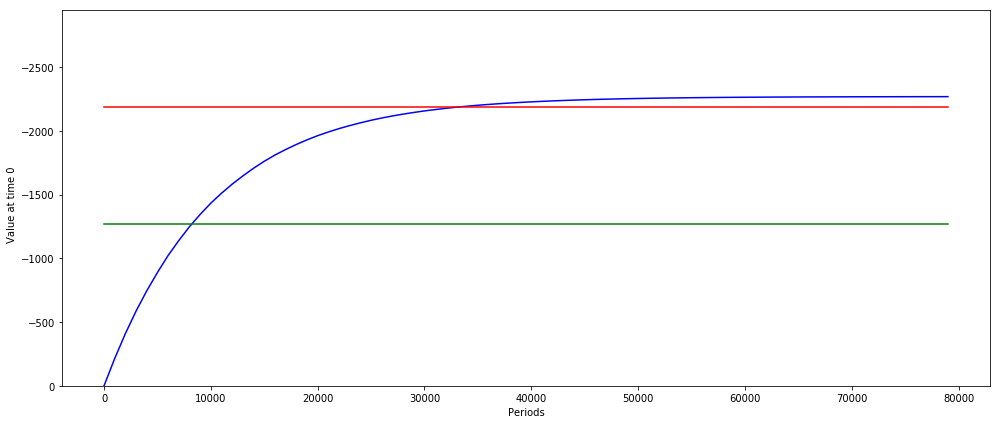

In [11]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(111)

ax.set_ylim([0, 1.3 * v_disc[-1]])

ax.set_ylabel(r"Value at time 0    ")
ax.set_xlabel(r"Periods")

ax.plot(periods, v_disc, color='blue', label='Discounted utility')
ax.plot(periods, v_exp_real, color='red', label='Expected value of the real transition probabilites at time 0')
ax.plot(periods, v_exp_known, color='green',label='Expected value of the known transition probabilites at time 0')

plt.tight_layout()

plt.plot()

If we look at the real transition probabilities compared to the ones known to the agent, there is already a big shift towards the highest reachable state. The resulting loss due to information, so the gap between the blue and red line, is very small though. The power of this method therefore needs a better setting. I am now discretisize the state space a lot finer and explore how different uncertainty set sizes are going to affect the performance of the transition probabilities:

In [4]:
init_dict

{'estimation': {'groups': 'group_4',
  'beta': 0.9999,
  'maint_func': 'linear',
  'binsize': 5000,
  'states': 90,
  'max_it': 1000},
 'simulation': {'beta': 0.9999,
  'periods': 80000,
  'seed': 123,
  'maint_func': 'linear',
  'buses': 200}}

In [17]:
# So now choose 2000 miles as binsize and estimate the model.
init_dict['estimation']['binsize'] = 1000
init_dict['estimation']['states'] = 450
init_dict['estimation']['max_it'] = 1000
repl_data = data_processing(init_dict['estimation'])
trans_results, state_count, cost_results = estimate(init_dict['estimation'], repl_data, repl_4=False)
print(trans_results, cost_results)

     fun: 7581.755519011549
     jac: array([-4291.98876953, -4292.00909424, -4292.01550293, -4291.99017334,
       -4292.00201416, -4291.99639893, -4292.00158691, -4291.63916016,
       -4290.96063232, -4292.23297119, -4291.89801025, -4290.65582275,
       -4290.68988037])
 message: 'Optimization terminated successfully.'
    nfev: 1336
     nit: 75
    njev: 75
  status: 0
 success: True
       x: array([2.86580358e-02, 8.10809022e-02, 2.79122939e-01, 2.46039699e-01,
       1.81733365e-01, 1.30242414e-01, 4.65982979e-02, 3.72817179e-03,
       4.66088648e-04, 6.98929448e-04, 9.31981148e-04, 4.66121756e-04,
       2.33055301e-04])       fun: 163.71080283705228
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , -0.00012221])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 11
   status: 0
  success: True
        x: array([10.13297317,  0.45596175])


In [18]:
# We seen above, that with the new estimation method, the paramters deviate not substantial from the "real" ones.
# I initialize the new values and roh now in the init_dict
init_dict['simulation']['known probs'] = trans_results['x']
init_dict['simulation']['params'] = cost_results['x']

In [ ]:
# The cost vector for the new parameters
num_states = 1500
costs = myopic_costs(num_states, lin_cost, init_dict['simulation']['params'])
known_trans_probs = np.array(init_dict['simulation']['known probs'])
known_trans_mat = create_transition_matrix(num_states, known_trans_probs)
ev_known = calc_fixp(num_states, known_trans_mat, costs, beta)
init_dict['simulation']['ev_known'] = ev_known

In [ ]:
# The worst case probabilites are calculated for a space size of 90. The size doesn't really makes a difference
# as my objective value is EV(0) anyway.
num_states = 250
roh = 2.5
worst_trans = get_worst_trans(init_dict['simulation'], roh, num_states)
init_dict['simulation']['real probs'] = worst_trans

In [8]:
# For a better understanding, I use real_trans_probs instead of worst_case in the following
real_trans_probs = np.array(init_dict['simulation']['real probs'])
real_trans_mat = create_transition_matrix(num_states, real_trans_probs)

In [12]:
df, unobs, utilities, num_states = simulate(init_dict['simulation'])

In [13]:
# The value of the real expected utility
real_trans_mat = create_transition_matrix(num_states, real_trans_probs)
ev_real = calc_fixp(num_states, real_trans_mat, costs, beta)

In [14]:
df.state.max()

897

[]

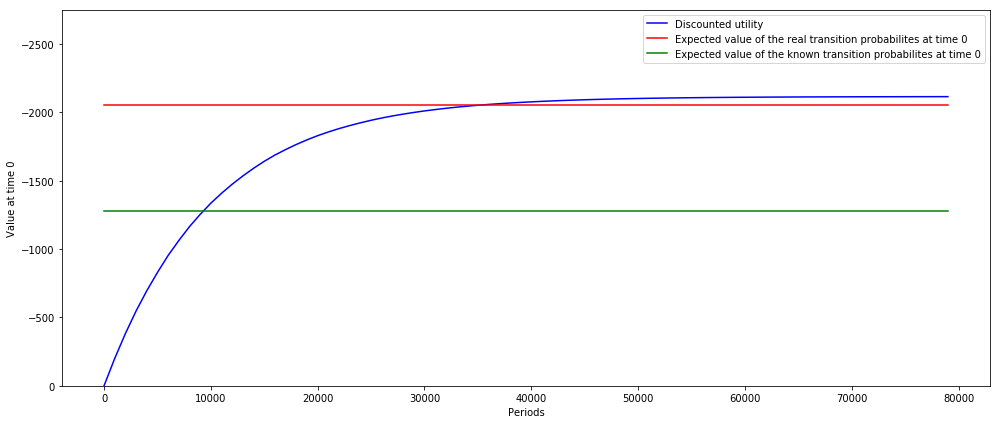

In [16]:
# The discounted utility of the decision strategy
v_disc = discount_utility(np.zeros(num_points), num_buses, gridsize, num_periods, utilities, beta)

# The arrays for plotting
v_exp_known = np.full(num_points, calc_ev_0(ev_known, unobs, num_buses))
v_exp_real = np.full(num_points, calc_ev_0(ev_real, unobs, num_buses))
periods = np.arange(0, num_periods, gridsize)


fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(111)

ax.set_ylim([0, 1.3 * v_disc[-1]])

ax.set_ylabel(r"Value at time 0")
ax.set_xlabel(r"Periods")

ax.plot(periods, v_disc, color='blue', label='Discounted utility')
ax.plot(periods, v_exp_real, color='red', label='Expected value of the real transition probabilites at time 0')
ax.plot(periods, v_exp_known, color='green',label='Expected value of the known transition probabilites at time 0')

plt.legend()
plt.tight_layout()

plt.plot()